# CNN

## Learning a Pattern
In this example, we will see how we can create a simple CNN that *learns to recognize an arbitrary pattern*.

Then we will see if such a network can learn also to repair a broken pattern.

Finally, we will see some applications of CNN to genomic medicine.

In [40]:
def signal(x):
    return np.round((3*np.sin(x))**2)

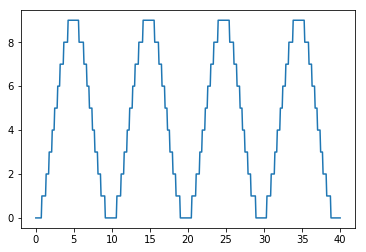

In [42]:
x = np.linspace(0,40, num=500)
plt.plot(x, signal(x))

In [ ]:
def pattern():
    

In [9]:
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
x = 

array([0, 0, 1, 3, 5, 7, 8, 9, 9, 8, 7, 5, 4, 2, 1, 0, 0, 1, 2, 4, 6, 7,
       9, 9, 9, 8, 6, 4, 3, 1, 0, 0, 1, 2, 3, 5, 7, 8, 9, 9, 8, 7, 5, 3,
       2, 1, 0, 0, 1, 3])

In [13]:
mcolors.cnames

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3